# Find the fingerprints of ENSO and the IPO in observed gridded datasets

Purpose
-------

    1.    Decompose the temperature time series into Intrinsic Mode Functions (IMFs) using EMD.
            i)  remove monthly climatology
            ii) remove linear trend over timeseries
    2.    Identify and correlate relevant IMFs with known indices for ENSO and IPO.
    3.    Compute slope of relationship between ENSO/IPO and variable of interest to quantify effect of ENSO/IPO


### IMPORTS

In [1]:

import sys
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# oceanographic
import gsw as gsw

# statistics
import scipy as sci
from scipy.signal import hilbert, periodogram
from PyEMD import EMD, CEEMDAN

# regridding package
import xesmf as xe

# Copernicus marine toolbox
#import copernicusmarine
#from pprint import pprint
#copernicusmarine.login()

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)
os.getcwd()


/g/data/es60/pjb581/miniforge3/envs/pyEMD_env/lib/python3.10/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.1
matplotlib version = 3.10.0
cmocean version = v3.0.3


'/g/data/es60/pjb581/SPC'

### LOAD DATA

In [4]:
%%time

datapath = "/g/data/es60/observations/OCNET_Hong2023"

# 1. Use glob to get all matching files
files = glob.glob(datapath + "/OCNET_chla_*.nc")

# 2. Pass the list to open_mfdataset
all_ds = xr.open_mfdataset(files, combine='by_coords').squeeze()
all_ds



CPU times: user 355 ms, sys: 173 ms, total: 529 ms
Wall time: 526 ms


<xarray.Dataset> Size: 209GB
Dimensions:    (time: 8400, Columns: 1440, Rows: 721, Longitude: 1440,
                Latitude: 721)
Coordinates:
  * time       (time) datetime64[ns] 67kB 2001-01-02 2001-01-03 ... 2024-01-01
Dimensions without coordinates: Columns, Rows, Longitude, Latitude
Data variables:
    longitude  (time, Columns, Rows) float64 70GB dask.array<chunksize=(365, 1440, 721), meta=np.ndarray>
    latitude   (time, Columns, Rows) float64 70GB dask.array<chunksize=(365, 1440, 721), meta=np.ndarray>
    Chla       (time, Longitude, Latitude) float64 70GB dask.array<chunksize=(365, 1440, 721), meta=np.ndarray>

## take monthly means of the Chl-a

In [5]:
%%time

monthly_ds = all_ds.resample(time='ME').mean()


CPU times: user 3.21 s, sys: 61.8 ms, total: 3.28 s
Wall time: 3.53 s


## Remove the Rows and Columns dimensions

In [6]:
%%time

chl = xr.DataArray(
    monthly_ds['Chla'].sel(time=slice("2001-01-01","2023-12-31")).values,
    coords={
        "time": monthly_ds.coords['time'].sel(time=slice("2001-01-01","2023-12-31")).values,
        "longitude": monthly_ds['longitude'].isel(time=0, Rows=0).values,
        "latitude": monthly_ds['latitude'].isel(time=0, Columns=0).values,
    },
    dims=['time', 'longitude', 'latitude'],
    name='chlorophyll'
)

chl = chl.transpose("time", "latitude", "longitude")
chl


CPU times: user 2min 56s, sys: 1min 46s, total: 4min 42s
Wall time: 2min 53s


<xarray.DataArray 'chlorophyll' (time: 276, latitude: 721, longitude: 1440)> Size: 2GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2kB 2001-01-31 2001-02-28 ... 2023-12-31
  * longitude  (longitude) float64 12kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * latitude   (latitude) float64 6kB 90.12 89.88 89.62 ... -89.38 -89.62 -89.88

## roll the longitude coordinate

In [7]:
%%time

chla = chl.roll(longitude=720, roll_coords=True)
print(chla.coords['longitude'])

lons = chla.coords['longitude'].values
lons[lons<0.0] += 360.0

chla = chla.assign_coords({"longitude":lons})


<xarray.DataArray 'longitude' (longitude: 1440)> Size: 12kB
array([ 0.125,  0.375,  0.625, ..., -0.625, -0.375, -0.125])
Coordinates:
  * longitude  (longitude) float64 12kB 0.125 0.375 0.625 ... -0.375 -0.125
CPU times: user 408 ms, sys: 607 ms, total: 1.01 s
Wall time: 1.01 s


## Save the array for later

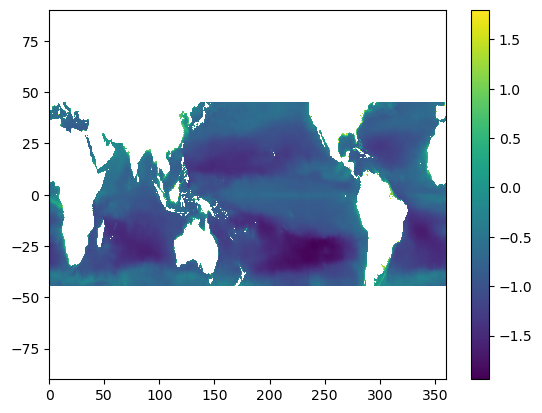

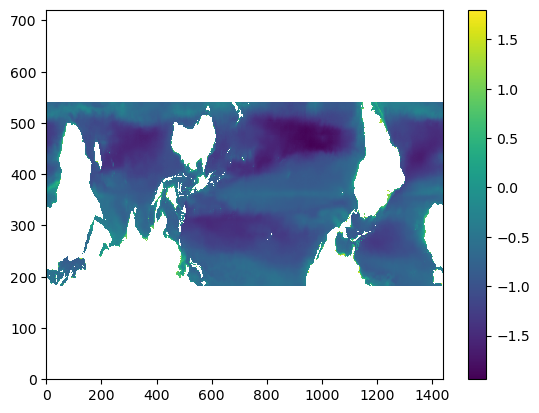

In [9]:
plt.figure()
plt.pcolormesh(chla.coords['longitude'], chla.coords['latitude'], np.log10(chla.isel(time=0)))
plt.colorbar()

plt.figure()
plt.pcolormesh(np.log10(chla.isel(time=0)))
plt.colorbar()


CPU times: user 16 s, sys: 1.92 s, total: 17.9 s
Wall time: 18 s


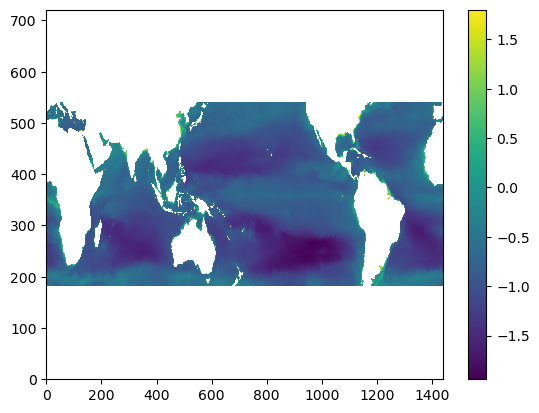

In [18]:
%%time

chla_flipped = chla.sortby('latitude')  # latitude goes from -90 to +90

plt.figure()
plt.pcolormesh(np.log10(chla_flipped.isel(time=0)))
plt.colorbar()

chla_flipped.name = "chlorophyll"
chla_flipped.attrs["long_name"] = "Surface chlorophyll-a concentration"
chla_flipped.attrs["units"] = "mg m-3"
chla_flipped.attrs["standard_name"] = "mass_concentration_of_chlorophyll_a_in_sea_water"

chla_flipped.coords["longitude"].attrs = {
    "units": "degrees_east",
    "standard_name": "longitude",
    "long_name": "Longitude",
    "axis": "X"
}

chla_flipped.coords["latitude"].attrs = {
    "units": "degrees_north",
    "standard_name": "latitude",
    "long_name": "Latitude",
    "axis": "Y"
}

chla_flipped.coords["time"].attrs = {
    "standard_name": "time",
    "long_name": "Time",
    "axis": "T",
}

os.chdir(wrkdir + "/data")
chla_flipped.to_netcdf(
    "chlorophyll_OCNET_flipped.nc",
    format="NETCDF4",
    encoding={
        "chlorophyll": {
            "zlib": True,
            "complevel": 4,
            "_FillValue": float("nan"),
            "dtype": "float32"
        }
    }
)


In [ ]:
os.chdir(wrkdir + "/data")

#os.remove("OCNET_chla_2001-2023.nc")

chla.to_netcdf("OCNET_chla_2001-2023.nc")


In [2]:
os.chdir(wrkdir + "/data")
chla = xr.open_dataset("OCNET_chla_2001-2023.nc")['chlorophyll-a']
chla

<xarray.DataArray 'chlorophyll-a' (time: 276, latitude: 721, longitude: 1440)> Size: 2GB
[286554240 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2kB 2001-01-31 2001-02-28 ... 2023-12-31
  * latitude   (latitude) float64 6kB 90.12 89.88 89.62 ... -89.38 -89.62 -89.88
  * longitude  (longitude) float64 12kB 0.125 0.375 0.625 ... 359.4 359.6 359.9

## remove the monthly climatology from the Chl-a

CPU times: user 2.95 s, sys: 6.2 s, total: 9.15 s
Wall time: 16.4 s


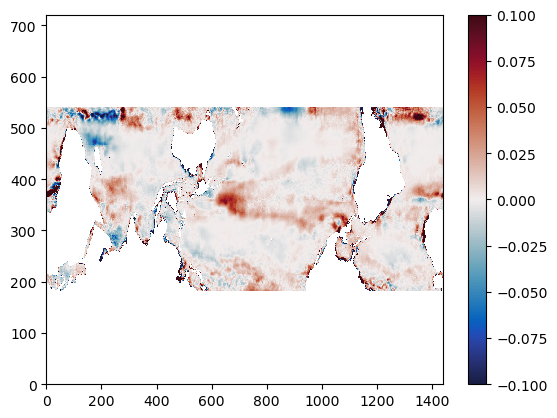

In [3]:
%%time

chla_clim = chla.groupby('time.month').mean('time')
chla_anom = chla.groupby('time.month') - chla_clim

plt.figure()
plt.pcolormesh(chla_anom.isel(time=0), cmap=cmo.balance, vmin=-0.1, vmax=0.1)
plt.colorbar()


In [4]:
%%time

### remove global trend
def detrend_1d(arr):
    """Remove the linear trend from a 1D array."""
    x = np.arange(len(arr))
    # Fit a linear trend
    coeffs = np.polyfit(x, arr, 1)
    trend = np.polyval(coeffs, x)
    # Remove the trend
    detrended = arr - trend
    return detrended

chla_detr = xr.apply_ufunc(
    detrend_1d,
    chla_anom,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[chla_anom.dtype]
)

chla_detr


CPU times: user 1min 37s, sys: 558 ms, total: 1min 37s
Wall time: 1min 38s


<xarray.DataArray 'chlorophyll-a' (latitude: 721, longitude: 1440, time: 276)> Size: 2GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2kB 2001-01-31 2001-02-28 ... 2023-12-31
  * latitude   (latitude) float64 6kB 90.12 89.88 89.62 ... -89.38 -89.62 -89.88
  * longitude  (longitude) float64 12kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
    month      (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

CPU times: user 3.14 s, sys: 537 ms, total: 3.68 s
Wall time: 3.68 s


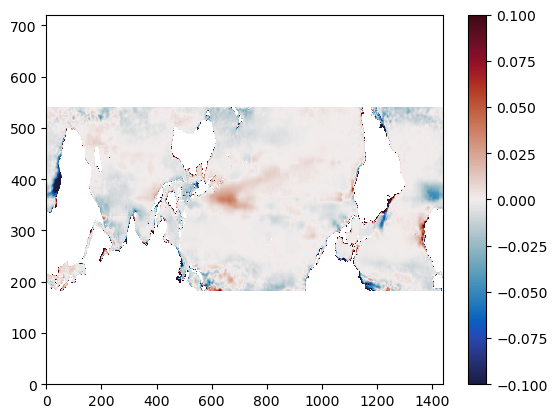

In [5]:
%%time

### retrive the linear least squares trend
chla_trend = chla_anom - chla_detr

### since the trends are linear, they can be described by one number (their slope)
### calculate the slope on a decadal timescale
dates = chla_anom.coords['time']
chla_trend = chla_trend.sel(time=dates[-1]) - chla_trend.sel(time=dates[0]) / len(dates) * 12 * 10

plt.figure()
plt.pcolormesh(chla_trend, cmap=cmo.balance, vmin=-0.1, vmax=0.1)
plt.colorbar()


## Undertake the decomposition at each grid cell across the ocean

In [6]:
%%time
from joblib import Parallel, delayed
import signal

# Setup CEEMDAN config
def make_ceemdan():
    ceemdan = CEEMDAN()
    ceemdan.noise_seed = 42
    ceemdan.num_siftings = 100
    ceemdan.Nstd = 0.2
    ceemdan.trials = 100
    return ceemdan

# Setup
years = np.arange(2001+0.5/12, 2023+11.51/12, 1/12)
times = chla_anom.coords['time'].values
lats = chla_anom.coords['latitude'].values
lons = chla_anom.coords['longitude'].values

def find_imf_freq_Hilbert(imfs, years):
    inst_freqs = []
    for imf in imfs:
        analytic_signal = hilbert(imf)
        amplitude_envelope = np.abs(analytic_signal)
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi * np.diff(years))
        inst_freqs.append(instantaneous_frequency)
    return np.array([np.mean(freq) for freq in inst_freqs])

def find_weights_from_freqs(imfs, bands):
    fs = 12  # Hz (cycles per year)
    n_imfs, n_time = imfs.shape
    n_bands = len(bands)
    weights = np.zeros((n_bands, n_imfs))
    # find the frequency power spectra of the different IMFs
    freqs = []
    power = []
    for i in range(n_imfs):
        f, p = periodogram(imfs[i,:], fs=fs, scaling='density', window='hann')
        freqs.append(f)
        power.append(p)
    freqs = np.array(freqs); power = np.array(power)
    # find the weights associated with that power spectra
    for i in range(n_imfs):
        total_power = np.sum(power[i,:])
        for j, (f_min, f_max) in enumerate(bands):
            mask = (freqs[i,:] >= f_min) & (freqs[i,:] < f_max)
            band_power = np.sum(power[i][mask])
            weights[j, i] = band_power / total_power if total_power > 0 else 0.0
    return weights

def set_bands(imfs, weights):
    return weights @ imfs

# Processing function for each grid cell
def process_cell(ix, iy):
    ceemdan = make_ceemdan()  # Create fresh CEEMDAN instance (safe in parallel)
    signal = chla_detr.isel(longitude=ix, latitude=iy).values
    if not np.all(np.isfinite(signal)) or np.all(signal == 0.0):
        return (ix, iy, None)
    try:
        imfs = ceemdan(signal)
        weights = find_weights_from_freqs(imfs, bands)
        grouped = set_bands(imfs, weights)
        return (ix, iy, grouped)
    except Exception as e:
        print(f"Error at ({ix}, {iy}): {e}")
        return (ix, iy, None)


CPU times: user 38 ms, sys: 43.2 ms, total: 81.2 ms
Wall time: 888 ms


In [ ]:
%%time

# Predefined cut-offs for frequency bands
bands = [
    (1.0, np.inf),       # Subannual
    (0.15, 1.0),         # Interannual
    (0.01, 0.15),        # Decadal
    (-np.inf, 0.01)       # Centennial or more
]

# Coordinate pairs
ntime = len(times)
nlat = len(lats)
nlon = len(lons)
coords = [(ix, iy) for ix in range(nlon) for iy in range(nlat)]

# Run in parallel
results = Parallel(n_jobs=112, backend='loky', verbose=1)(
    delayed(process_cell)(ix, iy) for (ix, iy) in coords
)


[Parallel(n_jobs=112)]: Using backend LokyBackend with 112 concurrent workers.
[Parallel(n_jobs=112)]: Done 226 tasks      | elapsed:    9.0s
[Parallel(n_jobs=112)]: Done 576 tasks      | elapsed:   35.0s
[Parallel(n_jobs=112)]: Done 1026 tasks      | elapsed:   47.6s
[Parallel(n_jobs=112)]: Done 1576 tasks      | elapsed:  1.1min
[Parallel(n_jobs=112)]: Done 2226 tasks      | elapsed:  1.6min
[Parallel(n_jobs=112)]: Done 2976 tasks      | elapsed:  2.1min
[Parallel(n_jobs=112)]: Done 3826 tasks      | elapsed:  2.7min
[Parallel(n_jobs=112)]: Done 4776 tasks      | elapsed:  3.6min
[Parallel(n_jobs=112)]: Done 5826 tasks      | elapsed:  4.2min
[Parallel(n_jobs=112)]: Done 6976 tasks      | elapsed:  5.2min
[Parallel(n_jobs=112)]: Done 8226 tasks      | elapsed:  5.9min
[Parallel(n_jobs=112)]: Done 9576 tasks      | elapsed:  6.8min
[Parallel(n_jobs=112)]: Done 11026 tasks      | elapsed:  7.9min
[Parallel(n_jobs=112)]: Done 12576 tasks      | elapsed:  9.2min
[Parallel(n_jobs=112)]: D

In [12]:
%%time

chla_imfs = np.zeros((4,len(times),len(lats),len(lons)))

# Assemble results
for ix, iy, grouped in results:
    if grouped is not None:
        chla_imfs[:, :, iy, ix] = grouped


CPU times: user 10.3 s, sys: 2.41 s, total: 12.7 s
Wall time: 12.7 s


In [14]:
%%time

# Create xarray Datasets
imfs_ds = xr.Dataset(
    {
        "chl_imfs": (["IMF", "time", "lat", "lon"], chla_imfs),
        "chl_anom": (["time", "lat", "lon"], chla_anom.values),
        "chl_detr": (["time", "lat", "lon"], chla_detr.transpose("time", "latitude", "longitude").values),
        "chl_trend": (["lat", "lon"], chla_trend.values),
    },
    coords={
        "IMF": np.arange(1,5,1),
        "time": dates,
        "lat": lats,
        "lon": lons,
    },
)

os.chdir(wrkdir + "/data/")

#os.remove("imfs_chl_CEEMDAN.nc")

imfs_ds.to_netcdf("imfs_chl_CEEMDAN.nc")


In [15]:
imfs_ds

<xarray.Dataset> Size: 14GB
Dimensions:    (IMF: 4, time: 276, lat: 721, lon: 1440)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2001-01-31 2001-02-28 ... 2023-12-31
    month      (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
  * IMF        (IMF) int64 32B 1 2 3 4
  * lat        (lat) float64 6kB 90.12 89.88 89.62 ... -89.38 -89.62 -89.88
  * lon        (lon) float64 12kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    chl_imfs   (IMF, time, lat, lon) float64 9GB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    chl_anom   (time, lat, lon) float64 2GB nan nan nan nan ... nan nan nan nan
    chl_detr   (time, lat, lon) float64 2GB nan nan nan nan ... nan nan nan nan
    chl_trend  (lat, lon) float64 8MB nan nan nan nan nan ... nan nan nan nan